### Walmart - TimeSeries Forecast - ARIMA Modelling

In this notebook, we shall be utilising the ARIMA Model to forecast the results and evaluate the RMSE value. 

#### ARIMA
‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

An ARIMA model is characterized by 3 terms: p, d, q

where,

- p is the order of the AR term

- q is the order of the MA term

- d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

Kaggle: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

In [26]:
# Importing Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

In [2]:
actual_df = pd.read_csv('E:/FAST/Semester-IV/Cloud Computing/Project/walmart_forecast_dataset.csv', sep = ',', header='infer')

In [3]:
actual_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### Data Exploration

Here we will have a look at how the data looks over a period of month.

In [4]:
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data

In [5]:
monthly_df = monthly_sales(actual_df)
monthly_df.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [6]:
# Duration of dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(actual_df)

1825 days
5.0 years


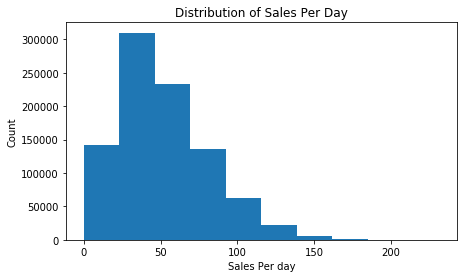

In [12]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(actual_df.sales)
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distribution of Sales Per Day")
    
sales_per_day()

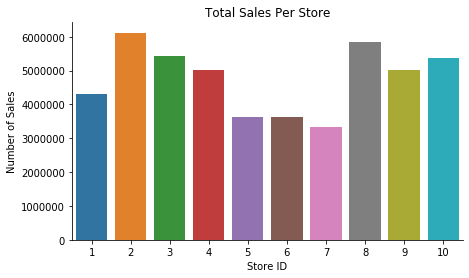

In [13]:
def sales_per_store():
    by_store = actual_df.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.store, by_store.sales)
    
    ax.set(xlabel = "Store ID",
           ylabel = "Number of Sales",
           title = "Total Sales Per Store")
    
    sns.despine()
    
sales_per_store()

In [14]:
# Average monthly sales

# Overall
avg_monthly_sales = monthly_df.sales.mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_monthly_sales_12month}")

Overall average monthly sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


#### Stationary Differencing

The purpose of differencing it to make the time series stationary.

In [19]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

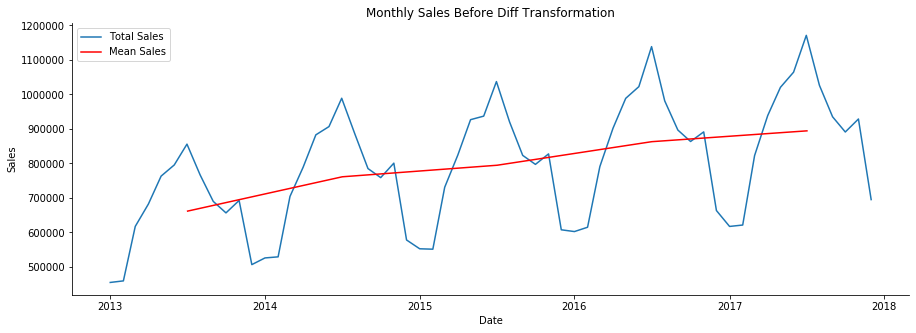

In [20]:
time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

In [21]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('E:/FAST/Semester-IV/Cloud Computing/Project/stationary_df.csv')
    return data

In [22]:
stationary_df = get_diff(monthly_df)

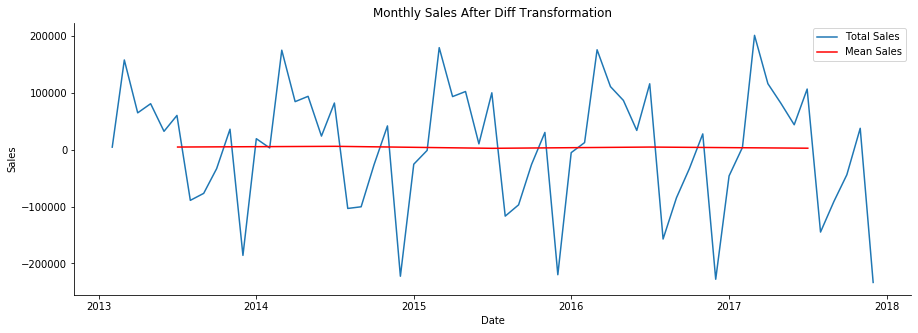

In [23]:
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

#### ARIMA Modelling

Here we will implement the ARIMA model to generate the RMSE values

In [18]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('E:/FAST/Semester-IV/Cloud Computing/Project/arima_df.csv')
    
    return dt_data

In [24]:
datetime_df = generate_arima_data(stationary_df)

In [25]:
datetime_df

,sales_diff
date,
2013-02-01,4513.0
2013-03-01,157965.0
2013-04-01,64892.0
2013-05-01,80968.0
2013-06-01,32355.0
2013-07-01,60325.0
2013-08-01,-89161.0
2013-09-01,-76854.0
2013-10-01,-33320.0


In [27]:
# load the data
def load_data():
    return pd.read_csv('E:/FAST/Semester-IV/Cloud Computing/Project/arima_df.csv').set_index('date')

arima_data = load_data()

In [28]:
arima_data.index = pd.to_datetime(arima_data.index)

#### SARIMAX 

An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

In [29]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

C:\Users\alina\Anaconda3\envs\alinew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\alina\Anaconda3\envs\alinew\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


RMSE: 14959.89346750362
MAE: 11265.335748809419
R2 Score: 0.9835642876206862


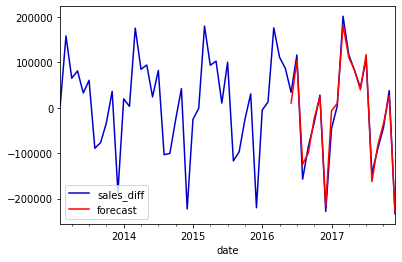

In [31]:
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(arima_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, arima_data, predictions = sarimax_model(arima_data)

ARIMA model has an RMSE value of around 14959.8934

The value is very high in comparison to the RMSE values generated from Amazon Forecast algorithms.